In [57]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sys.path.append('../src')

from mvt_brr import MVTModel

In [6]:
model = MVTModel(decay_type='exponential')

rich_proportions = np.array([0.2, 0.3, 0.5])
poor_proportions = np.array([0.5, 0.3, 0.2])

avg_reward_rate_rich = model.get_average_reward_rate(rich_proportions)
avg_reward_rate_poor = model.get_average_reward_rate(poor_proportions)
print(avg_reward_rate_rich, avg_reward_rate_poor)

21.86779075629432 18.563173124571552


In [26]:
class Agent:
    def __init__(self, decay_rate_means, decay_rate_stds, observation_var=0.01):
        self.decay_rate_means = decay_rate_means
        self.decay_rate_stds = decay_rate_stds
        self.observation_var = observation_var
        self.beliefs = {i+1: {'mean': decay_rate_means[i], 'std': decay_rate_stds[i]} for i in range(len(decay_rate_means))}

    def sample_decay_rate(self, patch_type):
        belief = self.beliefs[patch_type]
        return np.random.normal(belief['mean'], belief['std'])

    def update_belief(self, patch_type, observed_decay_rate):
        belief = self.beliefs[patch_type]
        prior_mean = belief['mean']
        prior_var = belief['std'] ** 2
        observation_var = self.observation_var

        # Bayesian update of the mean and variance
        posterior_mean = (prior_var * observed_decay_rate + observation_var * prior_mean) / (prior_var + observation_var)
        posterior_var = (prior_var * observation_var) / (prior_var + observation_var)

        # Update the agent's belief
        self.beliefs[patch_type]['mean'] = posterior_mean
        self.beliefs[patch_type]['std'] = np.sqrt(posterior_var)

    def decide_leave(self, reward, average_reward_rate):
        return reward < average_reward_rate

In [8]:
class Patch:
    def __init__(self, initial_yield, decay_rate, decay_type='exponential'):
        self.initial_yield = initial_yield
        self.decay_rate = decay_rate
        self.decay_type = decay_type
        self.time = 0
        self.harvesting = False

    def start_harvesting(self):
        self.harvesting = True
        self.time = 0

    def get_reward(self):
        if self.harvesting:
            if self.decay_type == 'exponential':
                reward = max(0, self.initial_yield * np.exp(-self.decay_rate * self.time))
            elif self.decay_type == 'linear':
                reward = max(0, self.initial_yield - self.decay_rate * self.time)
            else:
                raise ValueError("Invalid decay type. Use 'exponential' or 'linear'.")
            self.time += 1
            return reward
        else:
            return self.initial_yield

In [44]:
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")
# print(df_trials[:50])

In [52]:
class Simulation:
    def __init__(self, decay_rate_means, decay_rate_stds, avg_reward_rate_rich, avg_reward_rate_poor):
        self.decay_rate_means = decay_rate_means
        self.decay_rate_stds = decay_rate_stds
        self.avg_reward_rate_rich = avg_reward_rate_rich
        self.avg_reward_rate_poor = avg_reward_rate_poor
        self.patch_types = self.initialize_env()

    def initialize_env(self):
        patch_types = [
            {'type': 1, 'initial_yield': 32.5, 'decay_rate_mean': self.decay_rate_means[0], 'decay_rate_std': self.decay_rate_stds[0]},
            {'type': 2, 'initial_yield': 45, 'decay_rate_mean': self.decay_rate_means[1], 'decay_rate_std': self.decay_rate_stds[1]},
            {'type': 3, 'initial_yield': 57.5, 'decay_rate_mean': self.decay_rate_means[2], 'decay_rate_std': self.decay_rate_stds[2]}
        ]
        return patch_types

    def get_patch_info(self, patch_type):
        for patch in self.patch_types:
            if patch['type'] == patch_type:
                return patch
        raise ValueError("Patch type not found")

    def simulate_subject(self, subject_df, agent, env_avg_reward_rate, n_max=1000):
        leave_times = []
        for _, trial in subject_df.iterrows():
            patch_info = self.get_patch_info(trial['patch'])
            patch = Patch(
                patch_info['initial_yield'], 
                patch_info['decay_rate_mean']
            )
            patch.start_harvesting()

            # Agent samples decay rate from the distribution
            sampled_decay_rate = agent.sample_decay_rate(trial['patch'])
            patch.decay_rate = sampled_decay_rate

            for t in range(1, n_max + 1):
                reward = patch.get_reward()

                # Agent uses MVT-based deterministic rule to decide when to leave
                if agent.decide_leave(reward, env_avg_reward_rate):
                    leave_times.append(t)
                    leave_time_recorded = True
                    # Update belief about the decay rate based on the observed reward dynamics
                    observed_decay_rate = -np.log(reward / patch_info['initial_yield']) / t if t > 0 else sampled_decay_rate
                    agent.update_belief(trial['patch'], observed_decay_rate)
                    break
            if not leave_time_recorded:
                leave_times.append(n_max)

        return leave_times

    def run_simulation(self, df_trials):
        simulated_leave_times = []
        for subject in df_trials['sub'].unique():
            subject_df = df_trials[df_trials['sub'] == subject]
            for env in subject_df['env'].unique():
                env_avg_reward_rate = self.avg_reward_rate_rich if env == 1 else self.avg_reward_rate_poor
                agent = Agent(decay_rate_means=self.decay_rate_means, decay_rate_stds=self.decay_rate_stds)
                subject_env_df = subject_df[subject_df['env'] == env]
                leave_times = self.simulate_subject(subject_env_df, agent, env_avg_reward_rate)
                simulated_leave_times.extend(leave_times)
        
        # Append the simulated leave times to df_trials
        df_trials['simulated_leaveT'] = simulated_leave_times
        df_trials['simulated_dmLeave'] = df_trials['simulated_leaveT'] - df_trials['meanLT']
        
        return df_trials

In [73]:
# Define the decay rate means and standard deviations based on the study
decay_rate_means = [0.075, 0.075, 0.075]  # Fixed decay rate mean for all patch types
decay_rate_stds = [0.01, 0.01, 0.01]      # Initial uncertainty in the decay rate

# Initialize the simulation with these average reward rates
simulation = Simulation(decay_rate_means=decay_rate_means, decay_rate_stds=decay_rate_stds,
                        avg_reward_rate_rich=avg_reward_rate_rich, avg_reward_rate_poor=avg_reward_rate_poor)

df_trials_with_simulation = simulation.run_simulation(df_trials)

In [74]:
df_trials_with_simulation[:20]

,sub,patch,env,leaveT,meanLT,dmLeave,simulated_leaveT,simulated_dmLeave
0,1,3,1,45.034784,40.532927,4.501856,15,-25.532927
1,1,2,1,44.403900,40.532927,3.870973,13,-27.532927
2,1,3,1,61.168672,40.532927,20.635745,16,-24.532927
3,1,1,1,26.803514,40.532927,-13.729413,8,-32.532927
4,1,3,1,56.992002,40.532927,16.459075,16,-24.532927
5,1,2,1,46.472907,40.532927,5.939980,11,-29.532927
6,1,1,1,43.309626,40.532927,2.776699,8,-32.532927
7,1,3,1,58.564785,40.532927,18.031857,20,-20.532927
8,1,3,1,62.088330,40.532927,21.555402,12,-28.532927
9,1,2,1,38.427025,40.532927,-2.105903,13,-27.532927


In [75]:
MVT_rich, MVT_poor = model.run()
print(MVT_rich, MVT_poor)

[21.86779076] [18.56317312]
[ 5 10 13] [ 7 12 15]


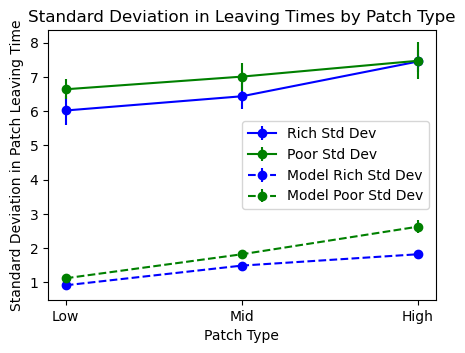

In [76]:
grouped = df_trials_with_simulation.groupby(['patch', 'env'])

std_observed = grouped['leaveT'].std().unstack()
std_simulated = grouped['simulated_leaveT'].std().unstack()

n_observed = grouped['leaveT'].count().unstack()
n_simulated = grouped['simulated_leaveT'].count().unstack()

sem_observed = std_observed / np.sqrt(n_observed)
sem_simulated = std_simulated / np.sqrt(n_simulated)

patch_types = ['Low', 'Mid', 'High']
patch_indices = np.arange(len(patch_types))

plt.figure(figsize=(5, 3.5))

plt.errorbar(patch_indices, std_observed[1], yerr=sem_observed[1], fmt='o-', color='blue', label='Rich Std Dev')
plt.errorbar(patch_indices, std_observed[2], yerr=sem_observed[2], fmt='o-', color='green', label='Poor Std Dev')

plt.errorbar(patch_indices, std_simulated[1], yerr=sem_simulated[1], fmt='--o', color='blue', label='Model Rich Std Dev')
plt.errorbar(patch_indices, std_simulated[2], yerr=sem_simulated[2], fmt='--o', color='green', label='Model Poor Std Dev')

plt.xticks(patch_indices, patch_types)
plt.xlabel('Patch Type')
plt.ylabel('Standard Deviation in Patch Leaving Time')
plt.title('Standard Deviation in Leaving Times by Patch Type')
plt.legend(loc='best')

plt.show()

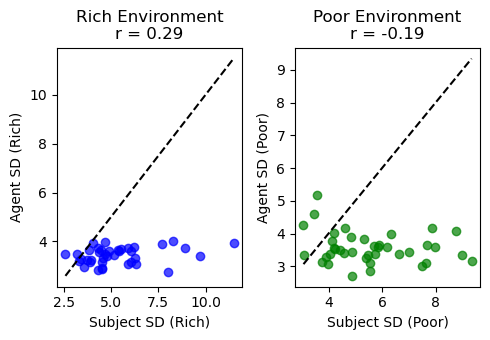

In [77]:
subject_sd_observed = df_trials_with_simulation.groupby(['sub', 'env'])['leaveT'].std().unstack()
subject_sd_simulated = df_trials_with_simulation.groupby(['sub', 'env'])['simulated_leaveT'].std().unstack()

rich_sd_observed = subject_sd_observed[1]
poor_sd_observed = subject_sd_observed[2]

rich_sd_simulated = subject_sd_simulated[1]
poor_sd_simulated = subject_sd_simulated[2]

corr_rich, _ = pearsonr(rich_sd_observed, rich_sd_simulated)
corr_poor, _ = pearsonr(poor_sd_observed, poor_sd_simulated)

plt.figure(figsize=(5, 3.5))

plt.subplot(1, 2, 1)
plt.scatter(rich_sd_observed, rich_sd_simulated, color='blue', alpha=0.7)
plt.plot([min(rich_sd_observed), max(rich_sd_observed)],
         [min(rich_sd_observed), max(rich_sd_observed)], 'k--')
plt.xlabel('Subject SD (Rich)')
plt.ylabel('Agent SD (Rich)')
plt.title(f'Rich Environment\nr = {corr_rich:.2f}')

plt.subplot(1, 2, 2)
plt.scatter(poor_sd_observed, poor_sd_simulated, color='green', alpha=0.7)
plt.plot([min(poor_sd_observed), max(poor_sd_observed)],
         [min(poor_sd_observed), max(poor_sd_observed)], 'k--')
plt.xlabel('Subject SD (Poor)')
plt.ylabel('Agent SD (Poor)')
plt.title(f'Poor Environment\nr = {corr_poor:.2f}')

plt.tight_layout()
plt.show()

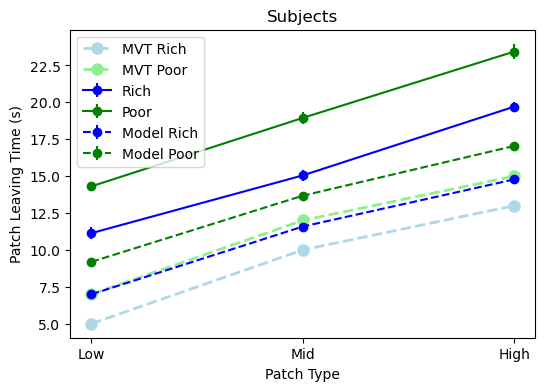

In [78]:
grouped = df_trials_with_simulation.groupby(['patch', 'env'])

# Mean leave times
mean_observed = grouped['leaveT'].mean().unstack()
mean_simulated = grouped['simulated_leaveT'].mean().unstack()

# Standard deviations
std_observed = grouped['leaveT'].std().unstack()
std_simulated = grouped['simulated_leaveT'].std().unstack()

# Sample sizes
n_observed = grouped['leaveT'].count().unstack()
n_simulated = grouped['simulated_leaveT'].count().unstack()

# Standard error of the mean (SEM)
sem_observed = std_observed / np.sqrt(n_observed)
sem_simulated = std_simulated / np.sqrt(n_simulated)

# Prepare data for plotting
patch_types = ['Low', 'Mid', 'High']
patch_indices = np.arange(len(patch_types))

# Plot the data
plt.figure(figsize=(6, 4))

# Observed data with SEM error bars
plt.errorbar(patch_indices, mean_observed[1], yerr=sem_observed[1], fmt='o-', color='blue', label='Rich')
plt.errorbar(patch_indices, mean_observed[2], yerr=sem_observed[2], fmt='o-', color='green', label='Poor')

# Simulated data with SEM error bars
plt.errorbar(patch_indices, mean_simulated[1], yerr=sem_simulated[1], fmt='--o', color='blue', label='Model Rich')
plt.errorbar(patch_indices, mean_simulated[2], yerr=sem_simulated[2], fmt='--o', color='green', label='Model Poor')

plt.plot(patch_indices, MVT_rich, 'o--', color='lightblue', label='MVT Rich', linewidth=2, markersize=8)
plt.plot(patch_indices, MVT_poor, 'o--', color='lightgreen', label='MVT Poor', linewidth=2, markersize=8)

# Customize the plot
plt.xticks(patch_indices, patch_types)
plt.xlabel('Patch Type')
plt.ylabel('Patch Leaving Time (s)')
plt.title('Subjects')
plt.legend(loc='best')

# Show the plot
plt.show()